In [5]:
import h5py
import numpy as np
import glob2
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd

sns.set(style="ticks")

In [6]:
# All params
Q_list = [0.15]
W_list = [0.15]
D_list = [0.6]
T_list = [0.00001, 0.0001, 0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
wb_list = [5.0]
decay_list = [18.0]

seed_list = list(np.arange(0, 25))

## Plot distance

In [7]:
plotting_mean = True

In [52]:
filename = "distance_data/distance_data_n=35.json"
density = filename[-7:-5]
savename = f"distance_data/distance_data_n={density}"
savename2 = f"distance_data/distance_vs_threshold_n={density}"
density, savename, savename2

('35',
 'distance_data/distance_data_n=35',
 'distance_data/distance_vs_threshold_n=35')

In [53]:
if plotting_mean:
    with open(filename) as f:
        distance_data = json.load(f)
else:
    with open(filename) as f:
        distance_data = json.load(f)

#### Distance for all trials

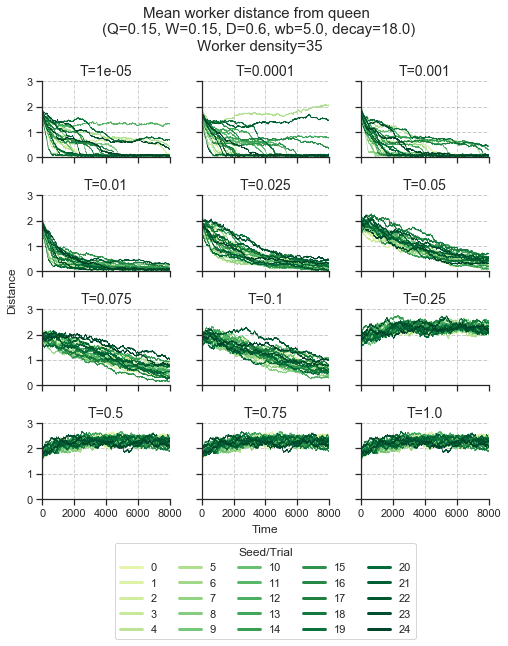

In [54]:
plt.rcParams["font.family"] = "Arial"
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(8, 8))

colors = plt.cm.YlGn(np.linspace(0.2, 1, len(seed_list)))

axes = axes.flatten()
for data_i, (ax, data) in enumerate(zip(axes, distance_data)):
    for trial_i, trials in enumerate(distance_data[data]):
        trials_list = distance_data[data][trials]
        
        ax.plot(trials_list, label=f"{seed_list[trial_i]}",
               color=colors[trial_i], linewidth=0.5)       
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title(f"T={T_list[data_i]}", fontsize=14)
        ax.xaxis.grid(b=True, color='k', alpha=0.2, linestyle='--', linewidth=1)
        ax.yaxis.grid(b=True, color=(0,0,0), alpha=0.2, linestyle='--', linewidth=1)
        ax.yaxis.zorder = -1
        plt.ylim(0, 3)
        plt.xlim(0, len(trials_list))
        plt.xticks(np.arange(0, len(trials_list)+1, 2000))

if plotting_mean:
    fig.suptitle(f"Mean worker distance from queen \n (Q={Q_list[0]}, W={W_list[0]}, D={D_list[0]}, wb={wb_list[0]}, decay={decay_list[0]}) \n Worker density={density}", fontsize=15)
else:
    fig.suptitle(f"Median worker distance from queen \n (Q={Q_list[0]}, W={W_list[0]}, D={D_list[0]}, wb={wb_list[0]}, decay={decay_list[0]})", fontsize=15)
fig.subplots_adjust(top=0.85)   

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
leg = ax.legend(loc='upper center', bbox_to_anchor=(-0.75, -0.5),
          fancybox=True, shadow=False, ncol=5, title="Seed/Trial")  
for line in leg.get_lines():
    line.set_linewidth(3)
    
# Add x and y labels for all
ax = fig.add_subplot(111, frameon=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Time', labelpad=25) 
ax.set_ylabel('Distance', labelpad=25)

fig.subplots_adjust(wspace=0.25, hspace=0.5)

if plotting_mean:
    plt.savefig(f"{savename}.pdf", bbox_inches='tight')
    plt.savefig(f"{savename}.png", bbox_inches='tight')
else:
    plt.savefig(f"{savename}.pdf", bbox_inches='tight')
    plt.savefig(f"{savename}.png", bbox_inches='tight')

### Avg distance for sets of params

In [55]:
# Plot mean of distances for each set of params
means_dict = {}
for data_i, data in enumerate(distance_data):
    means = []
    for trial_i, trials in enumerate(distance_data[data]):
        means.append(distance_data[data][trials])
    means_array = np.mean(np.array(means), axis=0)

    means_dict[data] = means_array

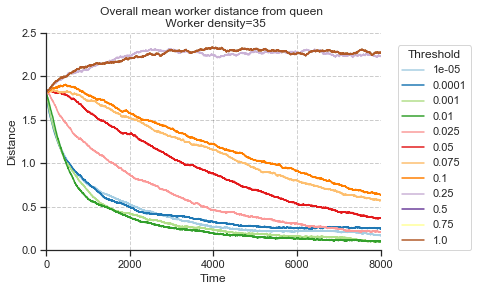

In [56]:
means_colors = plt.cm.Paired(np.linspace(0, 1, len(means_dict)))

for set_i, set_params in enumerate(means_dict):
    plt.plot(means_dict[set_params], label=f"{T_list[set_i]}", color=means_colors[set_i])

ax = plt.gca()
ax.xaxis.grid(b=True, color='k', alpha=0.2, linestyle='--', linewidth=1)
ax.yaxis.grid(b=True, color=(0,0,0), alpha=0.2, linestyle='--', linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0, 2.5)
plt.xlim(0, len(trials_list))
plt.xticks(np.arange(0, len(trials_list)+1, 2000))
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend(loc=(1.05,0), title="Threshold")

if plotting_mean:
    plt.title(f'Overall mean worker distance from queen \n Worker density={density}')
    plt.savefig(f"{savename}_overall.pdf", bbox_inches='tight')
    plt.savefig(f"{savename}_overall.png", bbox_inches='tight')
else:
    plt.title('Mean of median distance from queen')
    plt.savefig(f"{savename}_overall.pdf", bbox_inches='tight')
    plt.savefig(f"{savename}_overall.png", bbox_inches='tight')

plt.show()


### Extract optimal T at various time points

In [57]:
short_means_dict = {}
timepoints = np.arange(-1, 8000, 1000, dtype=int)
for key_i, (key, val) in enumerate(means_dict.items()):
    distance_array = val[timepoints[1:]]
    distance_array = np.insert(distance_array, 0, val[0])
    short_means_dict[T_list[key_i]] = distance_array

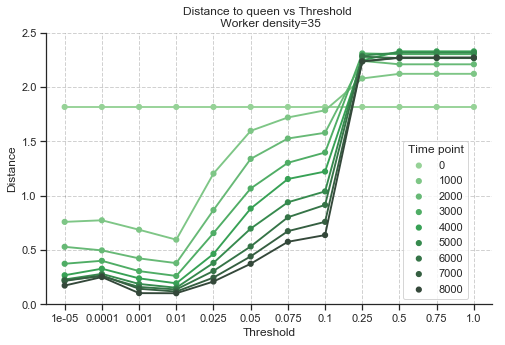

In [58]:
n_colors = len(timepoints)
colors = sns.set_palette(reversed(sns.color_palette("Greens_d", n_colors)), n_colors)

plt.figure(figsize=(8, 5))

df = pd.DataFrame.from_dict(short_means_dict, orient='index')
df.index.rename('Threshold', inplace=True)

stacked = df.stack().reset_index()
stacked.rename(columns={'level_1': 'Time point', 0: 'Distance'}, inplace=True)
stacked["Time point"] = stacked["Time point"] * 1000

sns.pointplot(data=stacked, x='Threshold', 
              y='Distance', hue='Time point', 
              join=True, palette=colors,
              linestyles="-", scale=0.7)
plt.ylim(0, 2.5)
plt.legend(loc=(0.8, 0.02), title="Time point")
plt.title(f"Distance to queen vs Threshold \n Worker density={density}")
ax = plt.gca()
ax.xaxis.grid(b=True, color='k', alpha=0.2, linestyle='--', linewidth=1)
ax.yaxis.grid(b=True, color='k', alpha=0.2, linestyle='--', linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(f"{savename2}.pdf", bbox_inches='tight')
plt.savefig(f"{savename2}.png", bbox_inches='tight')


### Line plot with standard deviation

In [520]:
n_experiments = len(T_list)
n_timesteps = 4000
n_trials = 25
total_matrix = np.zeros((n_experiments, n_trials, n_timesteps))
total_matrix.shape

seeds_list = []
param_list = []

for data_i, (data_key, data_val) in enumerate(distance_data.items()):
    single_set = []
    
    for trial_i, (trial_key, trial_vals) in enumerate(data_val.items()):
        single_set.append(trial_vals)
        
        for val in trial_vals:
            seeds_list.append(trial_key)
            param_list.append(data_key)

    single_set = np.array(single_set)
    total_matrix[data_i] = single_set

total_matrix.shape

(9, 25, 4000)

In [521]:
step_size = 50
total_matrix = total_matrix[:,:,::step_size]
seeds_list = np.array(seeds_list[::step_size])
param_list = np.array(param_list[::step_size])
n_timesteps = total_matrix.shape[2]
n_timesteps, total_matrix.shape

(80, (9, 25, 80))

In [522]:
distance_np = total_matrix.flatten()
distance_np.shape

(18000,)

In [523]:
distance_df = pd.DataFrame(data=distance_np, columns=['Distance'])
distance_df.head()

,Distance
0,1.727301
1,1.590528
2,1.464834
3,1.351706
4,1.278365


In [524]:
timesteps_np = np.tile(list(range(n_timesteps)), n_trials*n_experiments)
timesteps_np.shape

(18000,)

In [525]:
timesteps_df = pd.DataFrame(data=timesteps_np, columns=["Time"])
timesteps_df.head()

,Time
0,0
1,1
2,2
3,3
4,4


In [526]:
param_list_ = [f'T__{ele.split("_T")[-1].split("_wb")[0]}' for ele in param_list]

In [527]:
params_df = pd.DataFrame(data=param_list_, columns=['Threshold'])
params_df.head()

,Threshold
0,T__0.00001
1,T__0.00001
2,T__0.00001
3,T__0.00001
4,T__0.00001


In [528]:
df = pd.concat((distance_df, timesteps_df, params_df), axis=1)
df.head()

,Distance,Time,Threshold
0,1.727301,0,T__0.00001
1,1.590528,1,T__0.00001
2,1.464834,2,T__0.00001
3,1.351706,3,T__0.00001
4,1.278365,4,T__0.00001


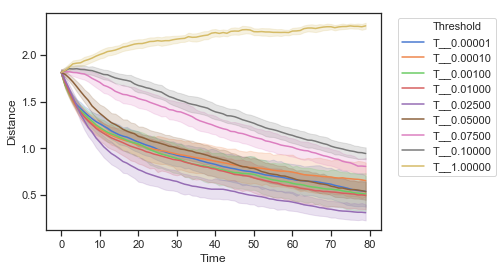

In [532]:
palette = sns.color_palette("muted", 9)
sns.lineplot(x='Time', y='Distance', hue='Threshold', data=df, estimator=np.mean, palette=palette)
plt.legend(loc=(1.05,0.25))
